# Project 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

In [21]:
import os, json
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns  
from sklearn.compose import ColumnTransformer

# Tests
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('data/glass.data', header=None)

# Name columns
df = df.rename(columns={0: 'Id', 1: 'RI', 2: 'Na', 3: 'Mg', 4: 'Al', 5: 'Si', 6: 'K', 7: 'Ca', 8: 'Ba', 9: 'Fe', 10: 'Type'})
# Change type of 'Type' to categorical
df['Type'] = df['Type'].astype('category')
# df['Type'] = df['Type'].cat.rename_categories({ 1: 'building_windows_float_processed',
#                                                 2: 'building_windows_non_float_processed',
#                                                 3: 'vehicle_windows_float_processed',
#                                                 4: 'vehicle_windows_non_float_processed',
#                                                 5: 'containers',
#                                                 6: 'tableware',
#                                                 7: 'headlamps'})
df['Type'] = df['Type'].cat.rename_categories({ 1: 'BW-FP',
                                                2: 'BW-NFP',
                                                3: 'VW-FP',
                                                4: 'VW-NFP',
                                                5: 'containers',
                                                6: 'tableware',
                                                7: 'headlamps'})

In [4]:
# Set random seed
RANDOM_SEED = 50
np.random.seed(RANDOM_SEED)

# 1. Regression

The plan is to predict $y = \texttt{RI}$ based on the chemical composition of the glass and the glass type (standardized $\tilde{\mathbf{X}}$).

<p style="color:red;">Note: we can't standardise up front, because it would introduce data leakage! So standardization must be done <b><u>within</u></b> each fold of cross-validation.</p>

### Part a)

Below, we predicted `RI` using all chemical elements and **with** `Type`

In [5]:
X_r = df.drop(columns=['Id'])  # Features
y_r = df['RI']
y_r = y_r.astype('float64')

# ! We can't standardize the data before splitting into folds, because it would introduce data leakage !

# print the first few rows of the modified dataframe
print(X_r.head())
# print the y variable
print(y_r.head())

numerical_features = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
categorical_features = ['Type']

# Define the ColumnTransformer to handle both numerical and categorical feature transformations
preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to the numerical columns (StandardScaler is fit/transform)
        ('num', StandardScaler(), numerical_features),
        # Apply OneHotEncoder to the categorical columns (OneHotEncoder is fit/transform)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe   Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0  BW-FP
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0  BW-FP
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0  BW-FP
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0  BW-FP
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0  BW-FP
0    1.52101
1    1.51761
2    1.51618
3    1.51766
4    1.51742
Name: RI, dtype: float64


Processing lambda 1.0000e-02, Fold 1/10
Processing lambda 1.0000e-02, Fold 2/10
Processing lambda 1.0000e-02, Fold 3/10
Processing lambda 1.0000e-02, Fold 4/10
Processing lambda 1.0000e-02, Fold 5/10
Processing lambda 1.0000e-02, Fold 6/10
Processing lambda 1.0000e-02, Fold 7/10
Processing lambda 1.0000e-02, Fold 8/10
Processing lambda 1.0000e-02, Fold 9/10
Processing lambda 1.0000e-02, Fold 10/10
Lambda: 1.0000e-02	 Average MSE (over folds): 0.0000
Processing lambda 1.3895e-02, Fold 1/10
Processing lambda 1.3895e-02, Fold 2/10
Processing lambda 1.3895e-02, Fold 3/10
Processing lambda 1.3895e-02, Fold 4/10
Processing lambda 1.3895e-02, Fold 5/10
Processing lambda 1.3895e-02, Fold 6/10
Processing lambda 1.3895e-02, Fold 7/10
Processing lambda 1.3895e-02, Fold 8/10
Processing lambda 1.3895e-02, Fold 9/10
Processing lambda 1.3895e-02, Fold 10/10
Lambda: 1.3895e-02	 Average MSE (over folds): 0.0000
Processing lambda 1.9307e-02, Fold 1/10
Processing lambda 1.9307e-02, Fold 2/10
Processing l

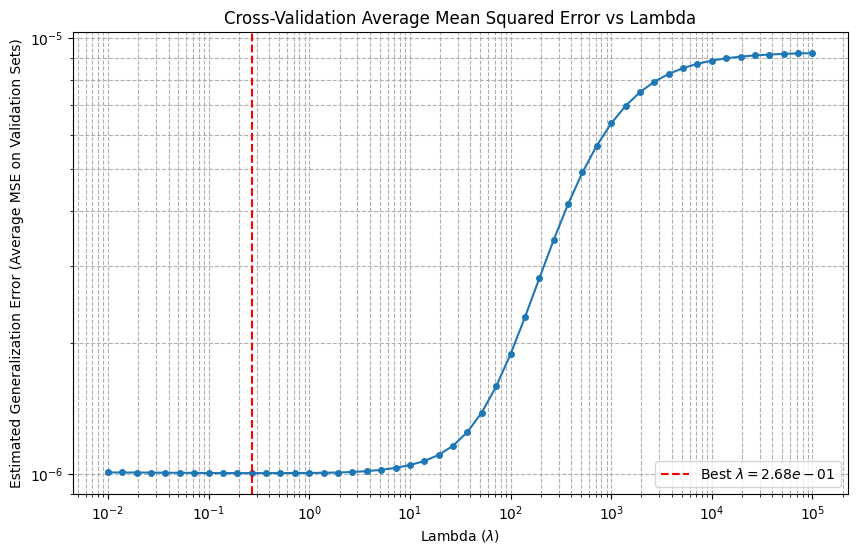

In [6]:
# Regularization parameters to try
lambdas = np.logspace(-2, 5, 50) 

# K-fold cross-validation setup
ten_fold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# List to store the *average* MSE for each lambda
MSEs_avg = []

# --- 3. Cross-Validation Loop ---
for l in lambdas:
    
    # 1. Define the Pipeline: Preprocessor MUST happen before Ridge Regression
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Handles scaling and encoding
        ('ridge', Ridge(alpha=l))       # Applies the regression model
    ])
    
    # List to collect MSE from each of the 10 folds for this specific lambda
    fold_MSEs = []
    fold_nb = 0
    
    for train_index, val_index in ten_fold.split(X_r):

        fold_nb += 1
        print(f'Processing lambda {l:.4e}, Fold {fold_nb}/10')

        # Use .iloc for proper pandas indexing
        X_train_fold, X_val_fold = X_r.iloc[train_index], X_r.iloc[val_index]
        y_train_fold, y_val_fold = y_r.iloc[train_index], y_r.iloc[val_index]
        
        # Fit the pipeline on the training fold (Scaler and Encoder learn from X_train_fold)
        model_pipeline.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold (Transformation is applied using the train stats)
        y_val_pred = model_pipeline.predict(X_val_fold)

        # Compute Mean Squared Error for this fold
        MSE = np.mean((y_val_fold - y_val_pred) ** 2)
        fold_MSEs.append(MSE)
    
    # Calculate the AVERAGE MSE over the 10 folds for this lambda (estimate of generalization error)
    avg_MSE = np.mean(fold_MSEs)
    MSEs_avg.append(avg_MSE)
    
    print(f'Lambda: {l:.4e}\t Average MSE (over folds): {avg_MSE:.4f}')

# --- 4. Results and Plotting ---

# Find the index of the minimum average MSE
min_mse_index = np.argmin(MSEs_avg)

# Find the best lambda
best_lambda = lambdas[min_mse_index]
min_avg_mse = MSEs_avg[min_mse_index]

print(f'Best lambda: {best_lambda:.4e} with minimum AVERAGE MSE: {min_avg_mse:.4e}')

# Plot MSE vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, MSEs_avg, marker='o', linestyle='-', markersize=4) 
plt.axvline(best_lambda, color='r', linestyle='--', label=f'Best $\lambda = {best_lambda:.2e}$')
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('Estimated Generalization Error (Average MSE on Validation Sets)')
plt.title('Cross-Validation Average Mean Squared Error vs Lambda')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [9]:
os.makedirs('figures', exist_ok=True)

# Save the plot as PDF (same plot as previously shown)
plt.figure(figsize=(10,6))
plt.plot(lambdas, MSEs_avg, marker='o', linestyle='-', markersize=4)
plt.axvline(best_lambda, color='r', linestyle='--', label=f'Best lambda = {best_lambda:.2e}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Lambda (λ)')
plt.ylabel('Average MSE (10-fold CV)')
plt.title('Ridge CV: avg MSE vs λ')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.savefig('figures/rlr_mse_vs_lambda.pdf')
plt.close()

# Save numeric arrays and best lambda to JSON for reproducibility
save_dict = {
    'lambdas': [float(x) for x in lambdas],
    'MSEs_avg': [float(x) for x in MSEs_avg],
    'best_lambda': float(best_lambda),
    'min_avg_mse': float(min_avg_mse)
}
with open('figures/rlr_cv_summary.json','w') as f:
    json.dump(save_dict, f, indent=2)

print("Saved RLR CV figure to: figures/rlr_mse_vs_lambda.pdf")
print("Saved numeric summary to: figures/rlr_cv_summary.json")


Saved RLR CV figure to: figures/rlr_mse_vs_lambda.pdf
Saved numeric summary to: figures/rlr_cv_summary.json


### Part b)

We will compare three models: 
1. the regularized linear regression model from the previous section
2. an artificial neural network (ANN)
3. a baseline model

We are interested in two questions: Is one model better than the other? Is either model better than a trivial baseline? We will attempt to answer these questions with **two-level cross-validation**.

The baseline model is the mean predictor, which always predicts the mean of the training set.

In [10]:
# Hyperparameters
lambdas = np.linspace(0.01, 3, 20)
# range from 1 to 1000: 1, 10, 20, ..., 990
hidden_units = np.concatenate(([1], np.arange(10, 1000, 10)))
MAX_ITER = 5000

# K-fold cross-validation
K1 = 10  # Outer folds
K2 = 10  # Inner folds
outer_kf = KFold(n_splits=K1, shuffle=True, random_state=RANDOM_SEED)
# Initialize lists to store the errors and best hyperparameters for each outer fold
results = {
    'i': [],
    'h_star': [],
    'E_ann': [],
    'lambda_star': [],
    'E_rlr': [],
    'E_baseline': []
}

# --- New structure to store all inner ANN validation errors for plotting ---
# Dimensions: K1 (Outer Folds) x len(hidden_units)
ann_val_errors_per_outer_fold = np.zeros((K1, len(hidden_units)))


print(f"Starting Nested Cross-Validation (K1={K1}, K2={K2})...")
print("-" * 50)

# --- 3. Outer loop to select model and hyperparameters ---
for i, (train_index, test_index) in enumerate(outer_kf.split(X_r, y_r)):

    fold_i = i + 1
    print(f"Processing Outer Fold {fold_i}/{K1}...")
    
    # Split data => D_i^train, D_i^test
    X_train_outer, y_train_outer = X_r.iloc[train_index], y_r.iloc[train_index]
    X_test_outer, y_test_outer = X_r.iloc[test_index], y_r.iloc[test_index]
    
    # Store fold index
    results['i'].append(fold_i)

    # Inner loops to estimate hyperparameters and errors

    # ------------------------------------------------------
    # --- Inner loop for Regularized Linear Regression (RLR) ---
    # ------------------------------------------------------
    
    inner_kf_rlr = KFold(n_splits=K2, shuffle=True, random_state=RANDOM_SEED)
    E_val_rlr = np.zeros(len(lambdas))
    
    # Train one model for each lambda...
    for j, l in enumerate(lambdas):

        E_val_inner = []

        # ... and for each inner fold split
        for train_inner_index, val_inner_index in inner_kf_rlr.split(X_train_outer, y_train_outer):

            # Split data => D_i^train, D_i^val
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer.iloc[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer.iloc[val_inner_index]
            
            # --- RLR Model with Preprocessing Pipeline ---
            model = Pipeline([
                ('preprocessor', preprocessor),
                ('ridge', Ridge(alpha=l))
            ])

            # Fit the pipeline (Preprocessor fits on X_train_inner)
            model.fit(X_train_inner, y_train_inner)
            
            # Predict on the inner validation set (Preprocessor transforms X_val_inner)
            y_pred_val = model.predict(X_val_inner)
            E_val_inner.append(np.mean((y_val_inner.values - y_pred_val)**2))

        E_val_rlr[j] = np.mean(E_val_inner)
        
    # Find best lambda based on the E_val's and store it
    best_lambda = lambdas[np.argmin(E_val_rlr)]
    results['lambda_star'].append(best_lambda)
    
    # Train RLR model on outer train set D_i^train with best lambda
    # --- Final RLR Model with Preprocessing Pipeline ---
    final_model_rlr = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge(alpha=best_lambda))
    ])

    final_model_rlr.fit(X_train_outer, y_train_outer)
    y_pred_rlr = final_model_rlr.predict(X_test_outer)

    # Compute E_i^test = (1/N^test) * sum (y_n - y_pred_n)^2
    E_test_rlr = np.mean((y_test_outer.values - y_pred_rlr)**2)

    # Store test error = estimated generalization error
    results['E_rlr'].append(E_test_rlr)


    # -----------------------------
    # --- Inner loop for ANN ---
    # -----------------------------

    inner_kf_ann = KFold(n_splits=K2, shuffle=True, random_state=RANDOM_SEED)
    E_val_ann = np.zeros(len(hidden_units))

    # Train one model for each number of hidden units...
    for j, h in enumerate(hidden_units):

        E_val_inner = []

        # ... and for each inner fold split
        for train_inner_index, val_inner_index in inner_kf_ann.split(X_train_outer, y_train_outer):

            # Split data
            # => D_i^train, D_i^val
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer.iloc[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer.iloc[val_inner_index]

            # --- ANN Model with Preprocessing Pipeline ---
            model = Pipeline([
                ('preprocessor', preprocessor),
                ('ann', MLPRegressor(hidden_layer_sizes=(h,), max_iter=MAX_ITER, random_state=RANDOM_SEED))
            ])

            # Fit the pipeline (Preprocessor fits on X_train_inner)
            model.fit(X_train_inner, y_train_inner)
            
            # Predict on the inner validation set (Preprocessor transforms X_val_inner)
            y_pred_val = model.predict(X_val_inner)

            E_val_inner.append(np.mean((y_val_inner.values - y_pred_val)**2))

        E_val_ann[j] = np.mean(E_val_inner)

    # Store the averaged inner validation errors for this outer fold
    ann_val_errors_per_outer_fold[i, :] = E_val_ann # <--- NEW: Store for plotting

    # Find best number of hidden units
    best_h = hidden_units[np.argmin(E_val_ann)]
    results['h_star'].append(best_h) # Store best hyperparameter

    # Train ANN model on outer train set with best h
    # --- Final ANN Model with Preprocessing Pipeline ---
    final_model_ann = Pipeline([
        ('preprocessor', preprocessor),
        ('ann', MLPRegressor(hidden_layer_sizes=(best_h,), max_iter=MAX_ITER, random_state=RANDOM_SEED))
    ])
    
    final_model_ann.fit(X_train_outer, y_train_outer)
    y_pred_ann = final_model_ann.predict(X_test_outer)

    # Compute E_i^test = (1/N^test) * sum (y_n - y_pred_n)^2
    E_test_ann = np.mean((y_test_outer.values - y_pred_ann)**2)

    # Store test error
    results['E_ann'].append(E_test_ann)


    # ----------------------
    # --- Baseline model ---
    # ----------------------

    # NOTE: The baseline model (mean of the target) does NOT require a pipeline 
    # as it only uses y_train_outer (the target values), not X features.
    baseline_pred = y_train_outer.mean()
    E_test_baseline = np.mean((y_test_outer.values - baseline_pred)**2)
    results['E_baseline'].append(E_test_baseline) 

# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results)

print("-" * 50)
print("\n--- Final Nested Cross-Validation Results ---")
print(results_df)

print("\n--- Summary Statistics ---")
print(results_df[['E_ann', 'E_rlr', 'E_baseline']].describe())

Starting Nested Cross-Validation (K1=10, K2=10)...
--------------------------------------------------
Processing Outer Fold 1/10...
Processing Outer Fold 2/10...
Processing Outer Fold 3/10...
Processing Outer Fold 4/10...
Processing Outer Fold 5/10...
Processing Outer Fold 6/10...
Processing Outer Fold 7/10...
Processing Outer Fold 8/10...
Processing Outer Fold 9/10...
Processing Outer Fold 10/10...
--------------------------------------------------

--- Final Nested Cross-Validation Results ---
    i  h_star     E_ann  lambda_star         E_rlr  E_baseline
0   1     500  0.026070     0.796842  1.599763e-06    0.000020
1   2     480  0.013269     2.842632  4.249184e-07    0.000012
2   3     230  0.032394     0.324737  4.820663e-07    0.000004
3   4     190  0.015919     0.167368  9.633122e-07    0.000005
4   5     120  0.010303     1.426316  1.500354e-06    0.000003
5   6     500  0.003226     0.010000  2.142198e-06    0.000006
6   7     120  0.016026     0.324737  1.284218e-06    0.00

In [14]:
# Saving ANN inner-validation error matrix & plot ANN selection curve
os.makedirs('figures', exist_ok=True)

np.save('figures/ann_val_errors_per_outer_fold.npy', ann_val_errors_per_outer_fold)
print("Saved ANN inner validation errors to: figures/ann_val_errors_per_outer_fold.npy")

# Create a plot of avg inner validation error vs hidden units (averaged across outer folds)
mean_ann_val = np.mean(ann_val_errors_per_outer_fold, axis=0)
plt.figure(figsize=(8,5))
plt.plot(hidden_units, mean_ann_val, marker='o', linestyle='-')
plt.xlabel('Hidden units (h)')
plt.ylabel('Average inner validation MSE (averaged across outer folds)')
plt.title('ANN inner-validation curve (average across outer folds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/ann_innerval_vs_h.pdf')
plt.close()
print("Saved ANN inner-val summary plot to: figures/ann_innerval_vs_h.pdf")


Saved ANN inner validation errors to: figures/ann_val_errors_per_outer_fold.npy
Saved ANN inner-val summary plot to: figures/ann_innerval_vs_h.pdf


In [15]:
# Open the npy
open_the_npy = np.load('figures/ann_val_errors_per_outer_fold.npy')


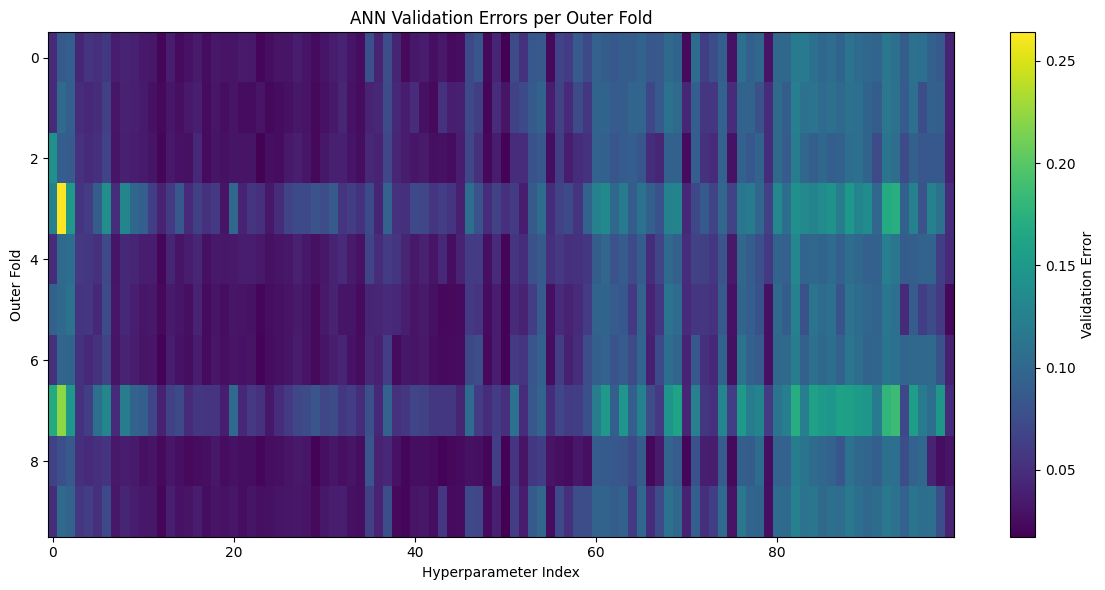

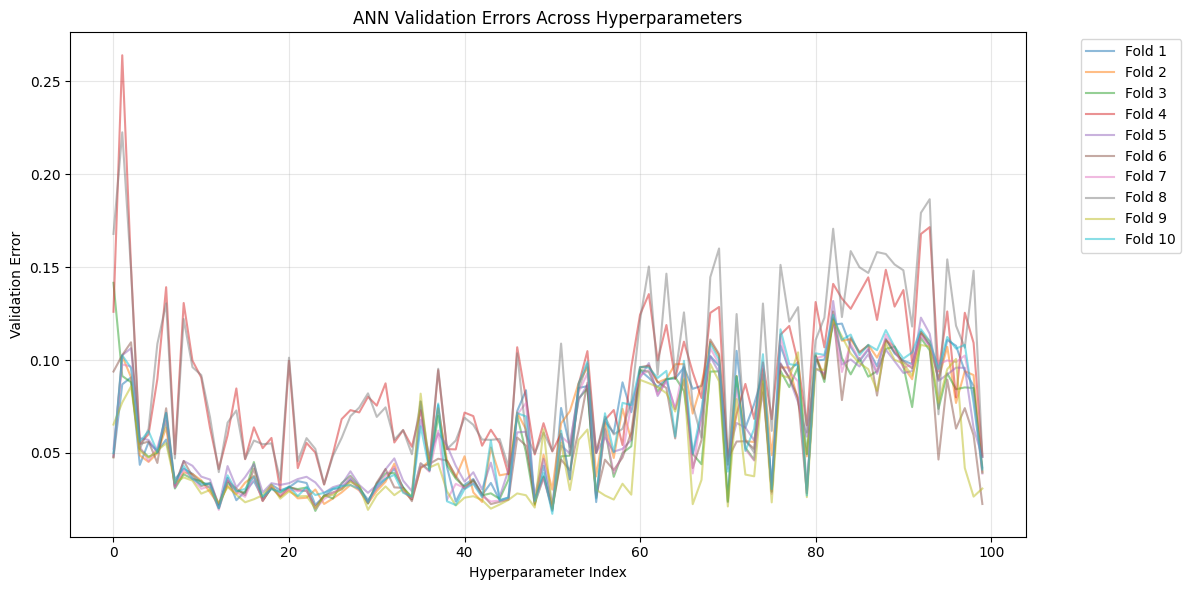

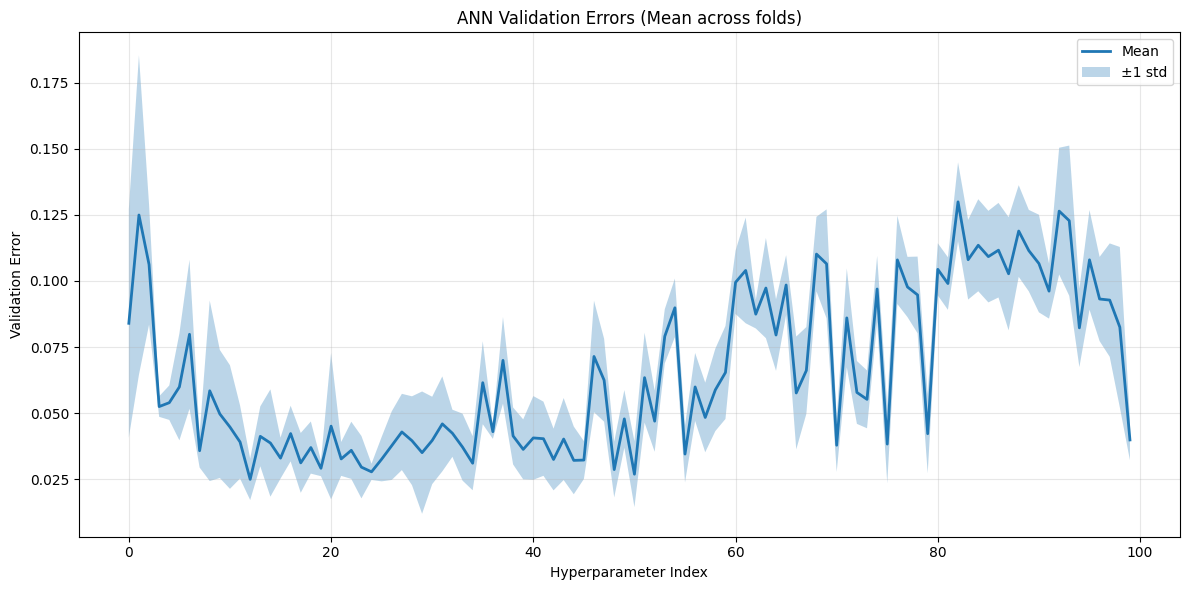

In [16]:
# Visualize the numpy array

# Heatmap
plt.figure(figsize=(12, 6))
plt.imshow(open_the_npy, cmap='viridis', aspect='auto')
plt.colorbar(label='Validation Error')
plt.xlabel('Hyperparameter Index')
plt.ylabel('Outer Fold')
plt.title('ANN Validation Errors per Outer Fold')
plt.tight_layout()
plt.show()

# Line plot
plt.figure(figsize=(12, 6))
for fold in range(10):
    plt.plot(open_the_npy[fold, :], alpha=0.5, label=f'Fold {fold+1}')
plt.xlabel('Hyperparameter Index')
plt.ylabel('Validation Error')
plt.title('ANN Validation Errors Across Hyperparameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mean + Std Dev plot (most useful one in our opinion)
plt.figure(figsize=(12, 6))
mean_errors = open_the_npy.mean(axis=0)
std_errors = open_the_npy.std(axis=0)

plt.plot(mean_errors, linewidth=2, label='Mean')
plt.fill_between(range(100), mean_errors - std_errors, mean_errors + std_errors, 
                 alpha=0.3, label='±1 std')
plt.xlabel('Hyperparameter Index')
plt.ylabel('Validation Error')
plt.title('ANN Validation Errors (Mean across folds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Final model

In [17]:
# Training Ridge on FULL dataset and print coefficients (fixed, regression-specific preprocessor)

# Prepare data
X_full = df.drop(columns=['Id','RI','Type'], errors='ignore')
y_full = df['RI']

# Define regression-specific preprocessor (numeric only)
num_features = X_full.columns.tolist()
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), num_features)
])

pipe_full = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('ridge', Ridge(alpha=best_lambda))
])
pipe_full.fit(X_full, y_full)

# Extract coefficients and save
ridge_step = pipe_full.named_steps['ridge']
feature_names = num_features
coefs = ridge_step.coef_.ravel()
intercept = float(ridge_step.intercept_)

os.makedirs('figures', exist_ok=True)
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df.to_csv('figures/rlr_coefficients.csv', index=False)

print("=== COPY THE FOLLOWING EXACT LINE INTO THE REPORT (final linear model fitted on FULL data) ===")
print(f"Intercept: {intercept:.10g}")
for f, c in zip(feature_names, coefs):
    print(f"{f}: {c:.10g}")
print("=== END OF MODEL PARAMETERS ===")



=== COPY THE FOLLOWING EXACT LINE INTO THE REPORT (final linear model fitted on FULL data) ===
Intercept: 1.518365421
Na: -0.0002574659853
Mg: 8.28374029e-05
Al: -0.0008566003247
Si: -0.001230770752
K: -0.0002729740513
Ca: 0.001898817879
Ba: 0.0006016976661
Fe: -1.922138819e-05
=== END OF MODEL PARAMETERS ===


In [ ]:
# VERIFY the regularized Ridge regression and create diagnostic figures 

os.makedirs('figures', exist_ok=True)

# Predict on full data
y_pred_full = pipe_full.predict(X_full)
residuals = y_full - y_pred_full

# 1. Predicted vs Actual plot (main verification figure)
plt.figure(figsize=(6,6))
plt.scatter(y_full, y_pred_full, alpha=0.7, edgecolor='k')
plt.plot([y_full.min(), y_full.max()],
         [y_full.min(), y_full.max()],
         'r--', label='Ideal (y = ŷ)')
plt.xlabel('Actual RI')
plt.ylabel('Predicted RI (Ridge)')
plt.title('Ridge regression: predicted vs actual RI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/rlr_predicted_vs_actual.pdf')
plt.close()

# 2. Residuals vs Predicted plot
plt.figure(figsize=(6,5))
plt.scatter(y_pred_full, residuals, alpha=0.7, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted RI (Ridge)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Ridge regression: residuals vs predicted RI')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/rlr_residuals_vs_predicted.pdf')
plt.close()

# Basic verification metrics
mse_full = mean_squared_error(y_full, y_pred_full)
r2_full = r2_score(y_full, y_pred_full)
print(f"Verification (Ridge on full data): MSE={mse_full:.6e}, R²={r2_full:.4f}")
print("Saved verification figures:")
print(" - figures/rlr_predicted_vs_actual.pdf")
print(" - figures/rlr_residuals_vs_predicted.pdf")


Verification (Ridge on full data): MSE=9.999345e-07, R²=0.8911
Saved verification figures:
 - figures/rlr_predicted_vs_actual.pdf
 - figures/rlr_residuals_vs_predicted.pdf


In [22]:
# Paired t-tests for regression models (ANN, RLR, Baseline)

E_ann = np.array(results_df['E_ann'].tolist())
E_rlr = np.array(results_df['E_rlr'].tolist())
E_base = np.array(results_df['E_baseline'].tolist())

def paired_stats(a, b):
    diff = a - b
    n = len(diff)
    mean = diff.mean()
    sd = diff.std(ddof=1)
    se = sd / (n**0.5)
    tstat, pval = stats.ttest_rel(a, b)
    # 95% CI for mean difference
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
    return {'mean_diff': mean, 'sd': sd, 't': tstat, 'p': pval, 'ci_low': ci_low, 'ci_high': ci_high}

pairs = {
    'ANN_vs_RLR': paired_stats(E_ann, E_rlr),
    'ANN_vs_Baseline': paired_stats(E_ann, E_base),
    'RLR_vs_Baseline': paired_stats(E_rlr, E_base)
}

# Save numeric results to JSON and CSV (for manual inspection)
os.makedirs('figures', exist_ok=True)
with open('figures/regression_pairwise_stats.json','w') as f:
    json.dump(pairs, f, indent=2, default=lambda x: float(x))

# Print concise table for copying into the report
print("Regression pairwise tests (ANN vs RLR vs Baseline):")
for name, s in pairs.items():
    print(f"{name}: mean_diff={s['mean_diff']:.8g}, sd={s['sd']:.8g}, t={s['t']:.6g}, p={s['p']:.6g}, 95%CI=({s['ci_low']:.8g}, {s['ci_high']:.8g})")

print("Saved regression pairwise stats to: figures/regression_pairwise_stats.json")


Regression pairwise tests (ANN vs RLR vs Baseline):
ANN_vs_RLR: mean_diff=0.024220412, sd=0.016855161, t=4.54411, p=0.00139767, 95%CI=(0.012162957, 0.036277868)
ANN_vs_Baseline: mean_diff=0.024212154, sd=0.016851428, t=4.54356, p=0.00139876, 95%CI=(0.012157369, 0.03626694)
RLR_vs_Baseline: mean_diff=-8.2580123e-06, sd=6.145326e-06, t=-4.24943, p=0.00214427, 95%CI=(-1.2654114e-05, -3.8619109e-06)
Saved regression pairwise stats to: figures/regression_pairwise_stats.json


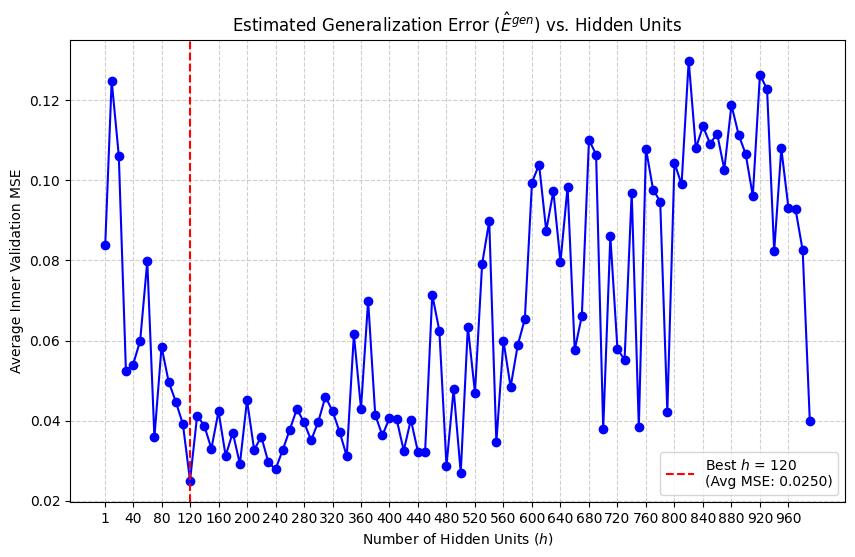

In [23]:
# --- 4. Plotting Generalization Error vs. Hidden Units (Model Complexity) ---

# Calculate the mean of the inner validation errors across all outer folds.
# This serves as the best estimate of the generalization error (E^gen) for each 'h'.
avg_ann_gen_error = np.mean(ann_val_errors_per_outer_fold, axis=0)
best_avg_error = np.min(avg_ann_gen_error)
best_h_for_plot = hidden_units[np.argmin(avg_ann_gen_error)]


plt.figure(figsize=(10, 6))
plt.plot(hidden_units, avg_ann_gen_error, marker='o', linestyle='-', color='blue')
plt.axvline(best_h_for_plot, color='red', linestyle='--', 
            label=f'Best $h$ = {best_h_for_plot}\n(Avg MSE: {best_avg_error:.4f})')
plt.title(r'Estimated Generalization Error ($\hat{E}^{gen}$) vs. Hidden Units')
plt.xlabel('Number of Hidden Units ($h$)')
plt.ylabel('Average Inner Validation MSE')
# plt.xscale('log')
# only plot a part of the ticks
plt.xticks(hidden_units[::4], labels=hidden_units[::4])
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

In [24]:
def generate_latex_table_content(df):
    """
    Generates only the data content rows and final \hline for the LaTeX table.
    Uses 5 significant figures for errors (scientific notation) and 3 for lambda.
    """
    
    latex_code = ""
    
    # Data rows
    for index, row in df.iterrows():
        i = int(row['i'])
        h_star = int(row['h_star'])
        
        # Errors: 5 significant figures using scientific notation (e.g., 1.2345e-02)
        E_ann = f"\\SI{{ {row['E_ann']:.3e} }}{{}}"
        E_rlr = f"\\SI{{ {row['E_rlr']:.3e} }}{{}}"
        E_baseline = f"\\SI{{ {row['E_baseline']:.3e} }}{{}}"

        # Lambda: 3 significant figures (general format)
        lambda_star = f"\\SI{{ {row['lambda_star']:.3g} }}{{}}"
        
        # Assemble the row
        row_str = f"{i} & {h_star} & {E_ann} & {lambda_star} & {E_rlr} & {E_baseline} \\\\ \n"
        latex_code += row_str
        
    return latex_code

In [25]:
latex_table_content_output = generate_latex_table_content(results_df)
print(latex_table_content_output)

1 & 500 & \SI{ 2.607e-02 }{} & \SI{ 0.797 }{} & \SI{ 1.600e-06 }{} & \SI{ 1.970e-05 }{} \\ 
2 & 480 & \SI{ 1.327e-02 }{} & \SI{ 2.84 }{} & \SI{ 4.249e-07 }{} & \SI{ 1.228e-05 }{} \\ 
3 & 230 & \SI{ 3.239e-02 }{} & \SI{ 0.325 }{} & \SI{ 4.821e-07 }{} & \SI{ 4.482e-06 }{} \\ 
4 & 190 & \SI{ 1.592e-02 }{} & \SI{ 0.167 }{} & \SI{ 9.633e-07 }{} & \SI{ 5.047e-06 }{} \\ 
5 & 120 & \SI{ 1.030e-02 }{} & \SI{ 1.43 }{} & \SI{ 1.500e-06 }{} & \SI{ 3.080e-06 }{} \\ 
6 & 500 & \SI{ 3.226e-03 }{} & \SI{ 0.01 }{} & \SI{ 2.142e-06 }{} & \SI{ 5.982e-06 }{} \\ 
7 & 120 & \SI{ 1.603e-02 }{} & \SI{ 0.325 }{} & \SI{ 1.284e-06 }{} & \SI{ 8.186e-06 }{} \\ 
8 & 240 & \SI{ 3.639e-02 }{} & \SI{ 0.01 }{} & \SI{ 1.018e-06 }{} & \SI{ 7.210e-06 }{} \\ 
9 & 290 & \SI{ 6.221e-02 }{} & \SI{ 1.27 }{} & \SI{ 1.637e-07 }{} & \SI{ 1.946e-05 }{} \\ 
10 & 500 & \SI{ 2.641e-02 }{} & \SI{ 3 }{} & \SI{ 5.225e-07 }{} & \SI{ 7.245e-06 }{} \\ 



## 2. Classification

We use the data $\mathbf{X}$, which has the refractive index (`RI` column) and oxide contents (`Na`, `Mg`, `Al`, `Si`, `K`, `Ca`, `Ba`, `Fe` columns), to predict the glass type (`Type` column)

So, we have $$\mathbf{X} \in \mathbb{R}^{214 \times 9}$$ and $$\mathbf{y} \in \{1, 2, 3, 5, 6\}^{214}$$

1. This is a **multi-class classification** problem
2. We will compare logistic regression, *method 2* and a baseline. The baseline predicts the most frequent class in the training set for all test samples.

<b style="color:red;">TODO: choose <i>one</i> of the following options for <i>method 2</i>:</b>

1. ANN (hyperparameter: number of hidden units $h$)
2. Classification trees (same complexity controller parameter as regression trees)
3. KNN (hyperparameter: number of neighbors $k$)
4. Naive Bayes (hyperparameter $b$)

In [34]:
X_c = df.drop(columns=['Id', 'Type'])
y_c = df['Type']

# Encode labels
le = LabelEncoder()
y_c = le.fit_transform(y_c)

### Training loop

In [27]:
print("\n" + "="*50)
print("STARTING CLASSIFICATION ANALYSIS (LogReg vs. Decision Tree)")
print("="*50)

# --- Data Preparation for Classification ---
# X_c contains only numerical features (Feature_A, B, C)
X_c = df.drop(columns=['Id', 'Type'])
# y_c is the categorical column 'Type'
y_c = df['Type']

# Encode labels (y_c must be a numpy array/series for proper indexing later)
le = LabelEncoder()
y_c = le.fit_transform(y_c)

# Hyperparameters
C_values = np.logspace(-3, 3, 20) 
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize storage for results
results_cls = {
    'i': [],
    'd_star': [],        # Best max_depth for Tree
    'E_tree': [],        # Test Error for Tree
    'C_star': [],        # Best C (1/lambda) for LogReg
    'E_logreg': [],      # Test Error for LogReg
    'E_baseline': []     # Test Error for Baseline
}

preprocessor_cls = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to the numerical columns
        ('num', StandardScaler(), X_c.columns)
    ]
)

# Outer loop
for i, (train_index, test_index) in enumerate(outer_kf.split(X_c, y_c)):
    fold_i = i + 1
    
    # Split data
    # NOTE: X_c uses iloc, y_c uses numpy indexing []
    X_train_outer, y_train_outer = X_c.iloc[train_index], y_c[train_index]
    X_test_outer, y_test_outer = X_c.iloc[test_index], y_c[test_index]
    
    results_cls['i'].append(fold_i)
    
    # ----------------------------------------------------
    # --- Inner loop for Regularized Logistic Regression (LogReg) ---
    # ----------------------------------------------------

    inner_kf_logreg = KFold(n_splits=K2, shuffle=True, random_state=42)
    E_val_logreg = np.zeros(len(C_values))
    
    for j, C_val in enumerate(C_values):
        E_val_inner = []
        for train_inner_index, val_inner_index in inner_kf_logreg.split(X_train_outer, y_train_outer):

            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer[val_inner_index]
            
            # --- LogReg Model with Preprocessing Pipeline (Corrected) ---
            # StandardScaler is required for regularization methods like LogReg
            model = Pipeline([
                ('preprocessor', preprocessor_cls),
                ('logreg', LogisticRegression(C=C_val, penalty='l2', solver='liblinear', max_iter=5000, random_state=42))
            ])
            
            # Fit the pipeline (Preprocessor fits on X_train_inner)
            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)
            
            # Error = Misclassification Rate = 1 - Accuracy
            E_val_inner.append(1 - accuracy_score(y_val_inner, y_pred_val))
        E_val_logreg[j] = np.mean(E_val_inner)
        
    # Find best C value (min error)
    best_C = C_values[np.argmin(E_val_logreg)]
    results_cls['C_star'].append(best_C)
    
    # Train final LogReg model on outer train set with best C
    final_model_logreg = Pipeline([
        ('preprocessor', preprocessor_cls),
        ('logreg', LogisticRegression(C=best_C, penalty='l2', solver='liblinear', max_iter=5000, random_state=42))
    ])

    final_model_logreg.fit(X_train_outer, y_train_outer)
    y_pred_logreg = final_model_logreg.predict(X_test_outer)
    E_test_logreg = 1 - accuracy_score(y_test_outer, y_pred_logreg)
    results_cls['E_logreg'].append(E_test_logreg)

    # --------------------------------------------
    # --- Inner loop for Classification Tree ---
    # --------------------------------------------
    inner_kf_tree = KFold(n_splits=K2, shuffle=True, random_state=42)
    E_val_tree = np.zeros(len(max_depths))

    for j, d in enumerate(max_depths):
        E_val_inner = []
        for train_inner_index, val_inner_index in inner_kf_tree.split(X_train_outer, y_train_outer):
            X_train_inner, y_train_inner = X_train_outer.iloc[train_inner_index], y_train_outer[train_inner_index]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_inner_index], y_train_outer[val_inner_index]

            # --- Classification Tree Model with Preprocessing Pipeline (Corrected) ---
            # The pipeline ensures X_train_inner has the same structure as X_val_inner
            model = Pipeline([
                ('preprocessor', preprocessor_cls),
                ('tree', DecisionTreeClassifier(max_depth=d, random_state=42))
            ])

            model.fit(X_train_inner, y_train_inner)
            y_pred_val = model.predict(X_val_inner)
            E_val_inner.append(1 - accuracy_score(y_val_inner, y_pred_val))
        E_val_tree[j] = np.mean(E_val_inner)

    # Find best max_depth
    best_d = max_depths[np.argmin(E_val_tree)]
    results_cls['d_star'].append(best_d)

    # Train final Tree model on outer train set with best d
    final_model_tree = Pipeline([
        ('preprocessor', preprocessor_cls),
        ('tree', DecisionTreeClassifier(max_depth=best_d, random_state=42))
    ])

    final_model_tree.fit(X_train_outer, y_train_outer)
    y_pred_tree = final_model_tree.predict(X_test_outer)
    E_test_tree = 1 - accuracy_score(y_test_outer, y_pred_tree)
    results_cls['E_tree'].append(E_test_tree)

    # ----------------------------
    # --- Baseline model (Classification) ---
    # ----------------------------
    # Baseline predicts the most dominant class in the training set
    (unique, counts) = np.unique(y_train_outer, return_counts=True)
    dominant_class = unique[np.argmax(counts)]
    
    baseline_pred = np.full_like(y_test_outer, dominant_class)
    E_test_baseline = 1 - accuracy_score(y_test_outer, baseline_pred)
    results_cls['E_baseline'].append(E_test_baseline)

# Convert results to a DataFrame
results_cls_df = pd.DataFrame(results_cls)

print("\n--- Final Classification Nested Cross-Validation Results ---")
print(results_cls_df)

print("\n--- Classification Summary Statistics ---")
print(results_cls_df[['E_tree', 'E_logreg', 'E_baseline']].describe())


STARTING CLASSIFICATION ANALYSIS (LogReg vs. Decision Tree)


/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass c


--- Final Classification Nested Cross-Validation Results ---
    i  d_star    E_tree      C_star  E_logreg  E_baseline
0   1       3  0.409091    2.976351  0.227273    0.545455
1   2       6  0.227273   12.742750  0.318182    0.500000
2   3      15  0.318182  112.883789  0.409091    0.818182
3   4       3  0.363636   26.366509  0.454545    0.909091
4   5       5  0.333333  112.883789  0.285714    0.571429
5   6       6  0.476190  233.572147  0.428571    0.809524
6   7       5  0.285714  233.572147  0.333333    0.666667
7   8      10  0.285714    2.976351  0.333333    0.761905
8   9       4  0.333333  233.572147  0.380952    0.666667
9  10       7  0.333333    1.438450  0.476190    0.809524

--- Classification Summary Statistics ---
          E_tree   E_logreg  E_baseline
count  10.000000  10.000000   10.000000
mean    0.336580   0.364719    0.705844
std     0.069100   0.078933    0.136547
min     0.227273   0.227273    0.500000
25%     0.293831   0.321970    0.595238
50%     0.333333 

In [28]:
# Paired t-tests for classification models (Tree, LogReg, Baseline)
os.makedirs('figures', exist_ok=True)

E_tree = np.array(results_cls_df['E_tree'].tolist())
E_logreg = np.array(results_cls_df['E_logreg'].tolist())
E_baseline_cls = np.array(results_cls_df['E_baseline'].tolist())

def paired_stats(a, b):
    diff = a - b
    n = len(diff)
    mean = diff.mean()
    sd = diff.std(ddof=1)
    se = sd / (n**0.5)
    tstat, pval = stats.ttest_rel(a, b)
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
    return {'mean_diff': mean, 'sd': sd, 't': tstat, 'p': pval, 'ci_low': ci_low, 'ci_high': ci_high}

pairs_cls = {
    'Tree_vs_LogReg': paired_stats(E_tree, E_logreg),
    'Tree_vs_Baseline': paired_stats(E_tree, E_baseline_cls),
    'LogReg_vs_Baseline': paired_stats(E_logreg, E_baseline_cls)
}

with open('figures/classification_pairwise_stats.json','w') as f:
    json.dump(pairs_cls, f, indent=2, default=lambda x: float(x))

print("Classification pairwise tests (Tree vs LogReg vs Baseline):")
for name, s in pairs_cls.items():
    print(f"{name}: mean_diff={s['mean_diff']:.8g}, sd={s['sd']:.8g}, t={s['t']:.6g}, p={s['p']:.6g}, 95%CI=({s['ci_low']:.8g}, {s['ci_high']:.8g})")

print("Saved classification pairwise stats to: figures/classification_pairwise_stats.json")


Classification pairwise tests (Tree vs LogReg vs Baseline):
Tree_vs_LogReg: mean_diff=-0.028138528, sd=0.095265421, t=-0.934041, p=0.374663, 95%CI=(-0.096287305, 0.040010249)
Tree_vs_Baseline: mean_diff=-0.36926407, sd=0.13101627, t=-8.91275, p=9.24565e-06, 95%CI=(-0.46298746, -0.27554068)
LogReg_vs_Baseline: mean_diff=-0.34112554, sd=0.080886635, t=-13.3364, p=3.11746e-07, 95%CI=(-0.39898835, -0.28326273)
Saved classification pairwise stats to: figures/classification_pairwise_stats.json


In [32]:
# This is entirely AI generated to facilitate report writing
# Generate LaTeX fragment files for tables (uses JSON files created earlier) 
os.makedirs('figures', exist_ok=True)

# Regression
with open('figures/regression_pairwise_stats.json','r') as f:
    reg = json.load(f)
rows = []
for name, s in reg.items():
    rows.append({
        'comparison': name.replace('_',' '),
        'mean_diff': s['mean_diff'],
        'sd': s['sd'],
        't': s['t'],
        'p': s['p'],
        'ci_low': s['ci_low'],
        'ci_high': s['ci_high']
    })
df_reg = pd.DataFrame(rows)
df_reg.to_latex('figures/regression_pairwise_table.tex', index=False, float_format="%.6g", caption="Pairwise tests for regression", label="tab:reg_pairwise")
print("Wrote LaTeX fragment: figures/regression_pairwise_table.tex")

# Classification
with open('figures/classification_pairwise_stats.json','r') as f:
    cls = json.load(f)
rows = []
for name, s in cls.items():
    rows.append({
        'comparison': name.replace('_',' '),
        'mean_diff': s['mean_diff'],
        'sd': s['sd'],
        't': s['t'],
        'p': s['p'],
        'ci_low': s['ci_low'],
        'ci_high': s['ci_high']
    })
df_cls = pd.DataFrame(rows)
df_cls.to_latex('figures/classification_pairwise_table.tex', index=False, float_format="%.6g", caption="Pairwise tests for classification", label="tab:cls_pairwise")
print("Wrote LaTeX fragment: figures/classification_pairwise_table.tex")


Wrote LaTeX fragment: figures/regression_pairwise_table.tex
Wrote LaTeX fragment: figures/classification_pairwise_table.tex


In [35]:
# Plots for per-outer-fold test errors (regression & classification)
os.makedirs('figures', exist_ok=True)

# Regression per-fold
plt.figure(figsize=(10,6))
plt.plot(results_df['i'], results_df['E_ann'], marker='o', label='ANN')
plt.plot(results_df['i'], results_df['E_rlr'], marker='s', label='RLR')
plt.plot(results_df['i'], results_df['E_baseline'], marker='x', label='Baseline')
plt.xlabel('Outer fold i')
plt.ylabel('Test error (MSE)')
plt.yscale('log')
plt.title('Regression: per-outer-fold test errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/regression_test_errors_by_fold.pdf')
plt.close()
print("Saved: figures/regression_test_errors_by_fold.pdf")

# Classification per-fold
plt.figure(figsize=(10,6))
plt.plot(results_cls_df['i'], results_cls_df['E_tree'], marker='o', label='Decision Tree')
plt.plot(results_cls_df['i'], results_cls_df['E_logreg'], marker='s', label='LogReg')
plt.plot(results_cls_df['i'], results_cls_df['E_baseline'], marker='x', label='Baseline')
plt.xlabel('Outer fold i')
plt.ylabel('Test error (misclassification rate)')
plt.yscale('log')
plt.title('Classification: per-outer-fold test errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/classification_test_errors_by_fold.pdf')
plt.close()
print("Saved: figures/classification_test_errors_by_fold.pdf")


Saved: figures/regression_test_errors_by_fold.pdf
Saved: figures/classification_test_errors_by_fold.pdf


In [36]:
def generate_latex_classification_table_content(df):
    """
    Generates only the data content rows and final \hline for the LaTeX classification table.
    Uses 5 significant figures for errors (scientific notation) and 3 for lambda (1/C).
    """
    
    latex_code = ""
    
    # Data rows
    for index, row in df.iterrows():
        i = int(row['i'])
        d_star = int(row['d_star'])
        
        # Errors (Misclassification Rate): 5 significant figures (e.g., 1.2345e-01)
        E_tree = f"\\SI{{ {row['E_tree']:.4f} }}{{}}"
        E_logreg = f"\\SI{{ {row['E_logreg']:.4f} }}{{}}"
        E_baseline = f"\\SI{{ {row['E_baseline']:.4f} }}{{}}"

        # Hyperparameters: max_depth is integer. lambda_i is 1/C_star, 3 significant figures
        lambda_star = 1 / row['C_star'] 
        lambda_star_str = f"\\SI{{ {lambda_star:.3g} }}{{}}"
        
        # Assemble the row
        # Note: The original table structure and headers must be adapted for these new models.
        # We will follow the format of the previous table columns:
        # i | h_i^* (d_i^*) | E_i^test (ANN/Tree) | lambda_i | E_i^test (RLR/LogReg) | E_i^test (Baseline)
        row_str = f"{i} & {d_star} & {E_tree} & {lambda_star_str} & {E_logreg} & {E_baseline} \\\\ \n"
        latex_code += row_str
        
    # Final \hline
    latex_code += "\\hline"
    
    return latex_code

# Generate and print the LaTeX code content
latex_table_content_output = generate_latex_classification_table_content(results_cls_df)


In [37]:
# Print LaTeX results
latex_table_content_output_cls = generate_latex_classification_table_content(results_cls_df)
print(latex_table_content_output_cls)

1 & 3 & \SI{ 0.4091 }{} & \SI{ 0.336 }{} & \SI{ 0.2273 }{} & \SI{ 0.5455 }{} \\ 
2 & 6 & \SI{ 0.2273 }{} & \SI{ 0.0785 }{} & \SI{ 0.3182 }{} & \SI{ 0.5000 }{} \\ 
3 & 15 & \SI{ 0.3182 }{} & \SI{ 0.00886 }{} & \SI{ 0.4091 }{} & \SI{ 0.8182 }{} \\ 
4 & 3 & \SI{ 0.3636 }{} & \SI{ 0.0379 }{} & \SI{ 0.4545 }{} & \SI{ 0.9091 }{} \\ 
5 & 5 & \SI{ 0.3333 }{} & \SI{ 0.00886 }{} & \SI{ 0.2857 }{} & \SI{ 0.5714 }{} \\ 
6 & 6 & \SI{ 0.4762 }{} & \SI{ 0.00428 }{} & \SI{ 0.4286 }{} & \SI{ 0.8095 }{} \\ 
7 & 5 & \SI{ 0.2857 }{} & \SI{ 0.00428 }{} & \SI{ 0.3333 }{} & \SI{ 0.6667 }{} \\ 
8 & 10 & \SI{ 0.2857 }{} & \SI{ 0.336 }{} & \SI{ 0.3333 }{} & \SI{ 0.7619 }{} \\ 
9 & 4 & \SI{ 0.3333 }{} & \SI{ 0.00428 }{} & \SI{ 0.3810 }{} & \SI{ 0.6667 }{} \\ 
10 & 7 & \SI{ 0.3333 }{} & \SI{ 0.695 }{} & \SI{ 0.4762 }{} & \SI{ 0.8095 }{} \\ 
\hline
